<a href="https://colab.research.google.com/github/Charlotte-99/Y3Project/blob/main/CNN_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Development

In this notebook, we experiment with building a model using a dataset containing 1000 CMB maps and 500 string maps.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential

In [2]:
# Change directory
os.chdir('drive/MyDrive/Project')

## Importing the data
In this section, we import and format out data into an appropriate format to build a dataset.

In [3]:
# Import data
cmb = np.load('cmb_1000_extracts.npy')
string = np.concatenate([np.load('string_map_extracts_1.npy'),
                         np.load('string_map_extracts_2.npy'),
                         np.load('string_map_extracts_3.npy')])

# Add channel dimension
cmb = cmb[..., np.newaxis]
string = string[..., np.newaxis]

In [4]:
print(cmb.shape)
print(string.shape)

(1000, 200, 200, 1)
(500, 200, 200, 1)


The cmb array contains 20 extracts each from 50 different full-sky maps, whilst the string array contains 166-167 extracts each from 3 different full-sky maps. 

Here, we shuffle the data to give a good mix of images. We then split the data into three different groups:


1.   Training set - this will be used to train our model. It will use 500 cmb maps and 250 string maps.
2.   Validation set - this will be used during training to check performance on unseen maps. It will contain 250 cmb maps and 125 string maps.
3. Test set - this will kept separate from training as a final check on our model's performance. It will contain 250 cmb maps and 125 string maps.

We will use the same labelling scheme as before: '0' for no string augmentations and '1' for string augmentations.

First we will shuffle the data.

In [5]:
# Shuffle cmb and string maps using different seeds.
np.random.RandomState(1).shuffle(cmb)
np.random.RandomState(99).shuffle(string)

Then we will create the training set.

In [86]:
# Slice cmb array
X_train_cmb = cmb[:500]

# Slice string array and also add placeholder string arrays for the cmb maps
# that we won't augment
nan_string = np.empty(shape=(250, 200, 200, 1))
nan_string[:] = np.NaN
X_train_string = np.concatenate([nan_string, string[:250]])

# Label data
y_train = np.concatenate([np.zeros(250), np.ones(250)])

# Shuffle all arrays with same seed
np.random.RandomState(7).shuffle(X_train_cmb)
np.random.RandomState(7).shuffle(X_train_string)
np.random.RandomState(7).shuffle(y_train)

print(X_train_cmb.shape)
print(X_train_string.shape)
print(y_train.shape)

(500, 200, 200, 1)
(500, 200, 200, 1)
(500, 1)


Then we will create the validation set.

In [87]:
# Slice cmb array
X_val_cmb = cmb[500:750]

# Slice string array
X_val_string = string[250:375]

# Create array split into two classes; first half of array will have no augmentations
alpha = 5e-6
X_val = np.concatenate([X_val_cmb[:125],
                        X_val_cmb[125:] + alpha*X_val_string])

# Create labels
y_val = np.concatenate([np.zeros(125), np.ones(125)])

# Shuffle X_val, y_val with same seed
np.random.RandomState(14).shuffle(X_val)
np.random.RandomState(14).shuffle(y_val)

print(X_val.shape)
print(y_val.shape)

(250, 200, 200, 1)
(250, 1)


And finally the test set.

In [88]:
# Slice cmb array
X_test_cmb = cmb[750:]

# Slice string array
X_test_string = string[375:]

# Create array split into two classes; first half of array will have no augmentations
alpha = 5e-6
X_test = np.concatenate([X_test_cmb[:125],
                        X_test_cmb[125:] + alpha*X_test_string])

# Create labels
y_test = np.concatenate([np.zeros(125), np.ones(125)])

# Shuffle X_val, y_val with same seed
np.random.RandomState(14).shuffle(X_test)
np.random.RandomState(14).shuffle(y_test)

print(X_test.shape)
print(y_test.shape)

(250, 200, 200, 1)
(250, 1)


## Building the pipeline and CNN
In this section we will build the pipeline and CNN. First we introduce two functions: a batch normalisation function and another that will perform random string augmentations on the fly on our training set.

In [89]:
def selective_string_maps(string_map, cmb_map, label):
  # label value
  N = np.int(label)

  # Transformation: rotate CMB map
  # Output: rotated CMB map and original label
  def rotation():
    cmb_rot = tf.image.rot90(cmb_map, tf.random.uniform(shape=[], minval=0,
                                          maxval=4, dtype=tf.int32))
    return cmb_rot, label

  # Transformation: introduce discontinuities to CMB map
  # Output: discontinuity map and original label
  def add_string():
    alpha = 5e-6
    string_rot = tf.image.rot90(string_map, tf.random.uniform(shape=[], minval=0,
                                maxval=4, dtype=tf.int32))
    string_scaled = tf.multiply(string_rot, alpha)
    cmb_rot = tf.image.rot90(cmb_map, tf.random.uniform(shape=[], minval=0,
                            maxval=4, dtype=tf.int32))
    aug_cmb = tf.add(cmb_rot, string_scaled)
    return aug_cmb, label

  return tf.cond(N == 0, true_fn=rotation, false_fn=add_string)

In [47]:
def batch_normalization(map, label):
  epsilon = 0.0001
  mean, variance = tf.nn.moments(map, axes=[0])
  map_normalized = (map - mean)/(variance + epsilon)
  return map_normalized, label  

Then we define our CNN.

In [92]:
# Build model
def build_model():
  model = Sequential([Conv2D(32, 3, activation='relu'),
                      Conv2D(32, 3, activation='relu'),
                      MaxPooling2D(2),
                      Flatten(),
                      Dense(128, activation='relu'),
                      Dense(2, activation='softmax')
                      ])
  optimizer = tf.keras.optimizers.Adam(0.0001)
  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
  return model

And finally we build our pipelines and test our CNN model.

In [93]:
# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train_string, X_train_cmb, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Train dataset pipeline
train_ds = train_ds.map(selective_string_maps)
train_ds = train_ds.shuffle(60)
train_ds = train_ds.batch(16)
train_ds = train_ds.map(batch_normalization)
train_ds = train_ds.prefetch(1)

# Validation dataset pipeline
val_ds = val_ds.batch(16)
val_ds = val_ds.map(batch_normalization)
val_ds = val_ds.prefetch(1)

# Test dataset pipeline
test_ds = test_ds.batch(16)
test_ds = test_ds.map(batch_normalization)
test_ds = test_ds.prefetch(1)

model = build_model()

history = model.fit(train_ds, epochs=40, verbose=1, validation_data=val_ds)
print(model.summary())

Epoch 1/40
32/32 [==============================] - 4s 105ms/step - loss: 1.9070 - accuracy: 0.4988 - val_loss: 0.7057 - val_accuracy: 0.5000
Epoch 2/40
32/32 [==============================] - 3s 97ms/step - loss: 0.6058 - accuracy: 0.5168 - val_loss: 0.7070 - val_accuracy: 0.5000
Epoch 3/40
32/32 [==============================] - 3s 98ms/step - loss: 0.6527 - accuracy: 0.5186 - val_loss: 0.6888 - val_accuracy: 0.5000
Epoch 4/40
32/32 [==============================] - 3s 98ms/step - loss: 0.6533 - accuracy: 0.5123 - val_loss: 0.7118 - val_accuracy: 0.5000
Epoch 5/40
32/32 [==============================] - 3s 96ms/step - loss: 0.6101 - accuracy: 0.5066 - val_loss: 0.6570 - val_accuracy: 0.5000
Epoch 6/40
32/32 [==============================] - 3s 98ms/step - loss: 0.5431 - accuracy: 0.5010 - val_loss: 0.6382 - val_accuracy: 0.5000
Epoch 7/40
32/32 [==============================] - 3s 99ms/step - loss: 0.5321 - accuracy: 0.5169 - val_loss: 0.6275 - val_accuracy: 0.5000
Epoch 8/40
3

KeyboardInterrupt: ignored

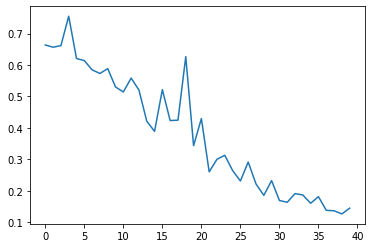

In [80]:
plt.plot(history.history['val_loss'])